# Análisis de Inundaciónes por municipio en México
Source: https://datos.gob.mx/busca/dataset/peligro-por-inundaciones-a-nivel-municipal

In [1]:
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import matplotlib.patches as mpatches
import requests
import numpy as np

In [2]:
floods_link = "http://servicios1.cenapred.unam.mx:6080/arcgis/rest/services/ANR/GoogleCrisis/MapServer/exts/GeoJSONServer/GeoJSON?query=1=1&layer=5&f=geojson"
floods = requests.get(floods_link).json()["features"]

In [3]:
# Diccionario con llave riesgo y valor vulnerabilidad
floods_risk_mun = defaultdict(list)

for ix, obj in enumerate(floods):
    mun_name = obj["properties"]["NOMBRE"]
    mun_risk = obj["properties"]["VULNERABIL"]
    floods_risk_mun[mun_risk].append(mun_name)
    print(f"At mun {ix+1}", end="\r")

At mun 2393

In [4]:
all_mun = [mun for group in floods_risk_mun.values() for mun in group]
len_all_mun = len(all_mun)
print(f"Total de municipios: {len_all_mun}")
for vul in floods_risk_mun:
    len_vul = len(floods_risk_mun[vul])
    print(f"Municipios con vulnerabilidad {vul:>5} (%): {len_vul / len_all_mun:.2%}")

Total de municipios: 2466
Municipios con vulnerabilidad MEDIA (%): 32.60%
Municipios con vulnerabilidad    ND (%): 57.91%
Municipios con vulnerabilidad  ALTA (%): 6.69%
Municipios con vulnerabilidad  BAJA (%): 2.80%


Del total de municipios, para más de la mitad de ellos no se cuenta con información para determinar el nivel de vulnerabilidad en cuanto a inundación.

In [21]:
# Legendas customizadas para el mapa
high_risk = mpatches.Patch(color="crimson", label="ALTA")
medium_risk = mpatches.Patch(color="khaki", label="MEDIA")
low_risk = mpatches.Patch(color="limegreen", label="BAJA")

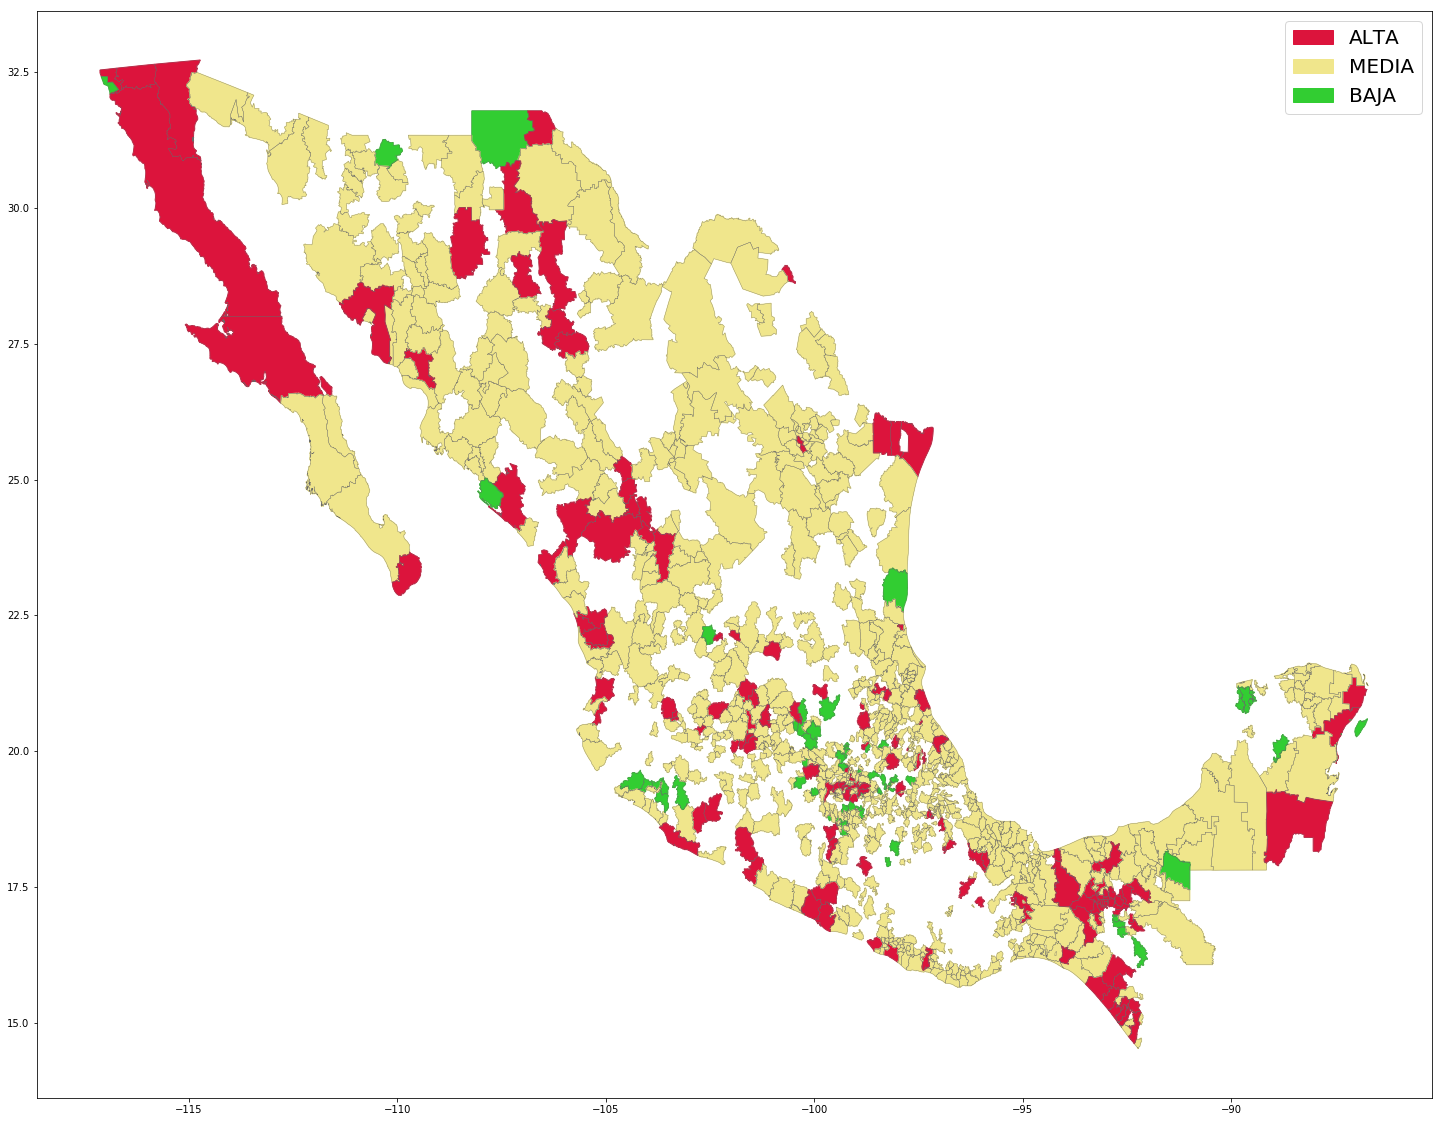

In [22]:
plt.figure(figsize=(25,20))
colors = {"ALTA":"crimson", "MEDIA":"khaki", "BAJA":"limegreen", "ND":"snow"}
for obj in floods:
    mun_name = obj["properties"]["NOMBRE"]
    if mun_name not in floods_risk_mun["ND"]:
        mun_loc = obj["geometry"]["coordinates"][0][0]
        mun_risk = obj["properties"]["VULNERABIL"]
        plt.fill(*np.array(mun_loc).T, c=colors[mun_risk], linewidth=1)
        plt.plot(*np.array(mun_loc).T, c="dimgray", linewidth=0.3)
plt.legend(handles=[high_risk, medium_risk, low_risk], fontsize=20)
plt.show()

In [161]:
mun_count = 0
for vul in floods_risk_mun:
    if vul != "ND":
        mun_count += len(floods_risk_mun[vul])

floods_risk_mun.pop("ND")
for vul in floods_risk_mun:
    len_vul = len(floods_risk_mun[vul])
    print(f"Municipios con vulnerabilidad {vul:>5} (%): {len_vul / mun_count:.2%}")

Municipios con vulnerabilidad MEDIA (%): 77.46%
Municipios con vulnerabilidad  ALTA (%): 15.90%
Municipios con vulnerabilidad  BAJA (%): 6.65%


De los munipicios con los que si se cuenta con información, al rededor del 77% de estos se encuentra en vulnerabilidad media; 16% en alta y el 7% en baja.

Guardamos los datos en un .csv para poder leerlo en otro `ipynb`


In [30]:
import csv
with open("data/high_risk.csv", "w") as f:
    headers = ["mun", "state"]
    writer = csv.DictWriter(f, headers)
    writer.writeheader()
    for mun_state in floods_risk_mun["ALTA"]:
        mun, state = mun_state.split("(")
        state = state.replace(")", "")
        writer.writerow({"mun": mun,
                          "state": state})
    